# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d import *
from MaaSSim.shared import prep_shared_rides

In [3]:
import pandas as pd
import logging
import matplotlib.pyplot as plt

In [4]:
# Load config
params = get_config('../../data/config/delft.json')  # load configuration

In [5]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 3

# Main experimental settings
params.nP = 2000 # travellers
params.nV = 20 # drivers
params.nD = 50 # days
params.simTime = 8 # hours

params.demand_structure.destinations_dispertion = -0.0003

In [6]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 10 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 0.25 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 10 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

params.evol.travellers.inform.prob_start = 0.2
params.evol.travellers.inform.beta = 0.2

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.63 #euro/km
params.platforms.min_fare = 6 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Properties alternative modes
params.alt_modes.pt.base_fare = 0.99 # euro
params.alt_modes.pt.km_fare = 0.174 # euro/km
params.alt_modes.pt.access_time = 10 * 60  #s, includes egress (not waiting)
params.alt_modes.pt.wait_time = 7.5 * 60 #s
params.alt_modes.car.km_cost = 0.5 # euro/km
params.alt_modes.car.access_time = 15 * 60 # s, includes egress
params.speeds.bike = 4 # m/s

# Mode choice parameters
params.mode_choice.ASC_car = -0.5 # util, rel to bike
params.mode_choice.ASC_rs = 0.5
params.mode_choice.ASC_pt = -1.0
params.mode_choice.beta_access = -0.0475 / 60 # util/s
params.mode_choice.beta_cost = -0.1515 # util/euro
params.mode_choice.beta_time_bike = -0.0693 / 60 #util/s
params.mode_choice.beta_time_moto = -0.0106 / 60
params.mode_choice.beta_wait_rs = -0.08 / 60
params.mode_choice.beta_wait_pt = -0.0398 / 60

# Demand settings
params.demand_structure.origins_dispertion = -0.0003
params.demand_structure.destinations_dispertion = -0.0003
params.dist_threshold_min = 0 # min dist
params.dist_threshold = 100000 # max dist

# Start time
params.t0 = pd.Timestamp.now()

In [7]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = True)
inData.passengers['informed'] = np.random.rand(params.nP) < params.evol.travellers.inform.prob_start
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [8]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    kpi_pax = D2D_kpi_pax,
                    f_driver_out = D2D_driver_out,
                    f_trav_out = d2d_no_request,
                    f_trav_mode = pax_mode_choice,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers(sim=sim,params=params)
    res_inf_driver = wom_driver(inData, params = params)
    inData.vehicles.informed = res_inf_driver
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos
    res_inf_trav = wom_trav(inData, params = params)
    inData.passengers.informed = res_inf_trav

evol_micro, evol_agg = D2D_summary(d2d=d2d) # multi-day stats

05-03-21 15:41:05-WARNING-Setting up 8h simulation at 2021-03-05 11:41:06 for 20 vehicles and 2000 passengers in Delft, Netherlands
05-03-21 15:41:17-WARNING-day 0: simulation time 10.3 s
05-03-21 15:41:19-WARNING-assertion tests for simulation results - passed
05-03-21 15:41:31-WARNING-day 1: simulation time 10.8 s
05-03-21 15:41:33-WARNING-assertion tests for simulation results - passed
05-03-21 15:41:48-WARNING-day 2: simulation time 13.3 s
05-03-21 15:41:50-WARNING-assertion tests for simulation results - passed
05-03-21 15:42:06-WARNING-day 3: simulation time 14.2 s
05-03-21 15:42:08-WARNING-assertion tests for simulation results - passed
05-03-21 15:42:26-WARNING-day 4: simulation time 16.5 s
05-03-21 15:42:28-WARNING-assertion tests for simulation results - passed
05-03-21 15:43:07-WARNING-day 5: simulation time 35.0 s
05-03-21 15:43:10-WARNING-assertion tests for simulation results - passed
05-03-21 15:43:53-WARNING-day 6: simulation time 39.9 s
05-03-21 15:43:55-WARNING-assert

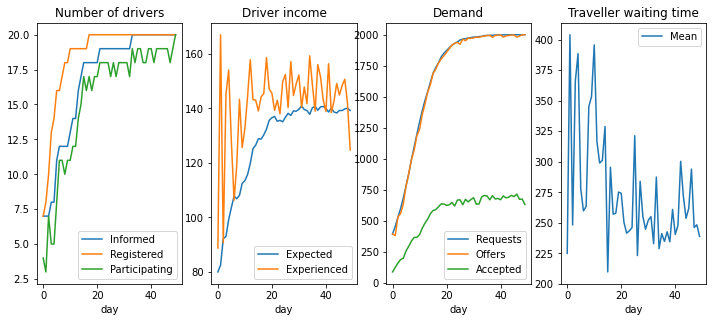

In [9]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (12,4.8))
evol_agg.supply[['regist','inform','particip']].plot(ax = axes[0])
axes[0].set_title('Number of drivers')
axes[0].legend(['Informed','Registered','Participating'])
evol_agg.supply[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[1])
axes[1].set_title('Driver income')
axes[1].legend(['Expected','Experienced'])

evol_agg.demand[['requests','gets_offer','accepts_offer']].plot(ax = axes[2])
axes[2].set_title('Demand')
axes[2].legend(['Requests','Offers','Accepted'])
evol_agg.demand[['mean_wait']].plot(ax = axes[3])
axes[3].set_title('Traveller waiting time')
axes[3].legend(['Mean'])